# Classifier 학습하기

## DATA

일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 때는 표준 Python 패키지를 이용하여 NumPy 배열로 불러온다. 그 후 그 배열을 torch.Tensor 로 변환시킨다.
- 이미지 : Pillow, OpenCV
- 오디오 : SciPy, LibROSA
- 텍스트 : Python, Cython, NLTK, SpaCy

특별히 영상 분야를 위한 torchvision이라는 패키지가 만들어져 있는데, 여기에는 ImageNet, CIFAR10, MNIST 같이 일반적으로 사용되는 데이터셋을 위한 data loader, 즉 torchvision.datasets 와 이미지용 데이터 변환기 (data transformer) 즉 torch.utils.data.DataLoader가 포함되어 있다.

이러한 기능은 매우 편리하며, 매번 유사한 코드를 작성하는 것을 피하게 해준다.

이 튜토리얼에서는 CIFAR10 dataset을 이용한다.

CIFAR-10 : (32, 32, 3) 으로 이루어진 이미지, 10개의 Class

# Image Classifier

1. torchvision을 통해 CIFAR10 dataset을 불러오고 Normalizing
2. CNN 정의
3. Loss function 정의
4. Training
5. Testing

# 1. CIFAR10 Load & Normalizing

torchvision 사용

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision dataset의 출력
- [0,1] 범위
- PILImage

Normalize
- [-1,1]의 범위로 정규화

In [2]:
from random import shuffle
from unittest import TestLoader


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), ((0.5, 0.5, 0.5)))]
                        )

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='../data',
                                        train=True,
                                        download=True,
                                        transform=transform
                                    )

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data',
                                        train=False,
                                        download=True,
                                        transform=transform
                                    )

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


shuffle를 사용하는 이유
- overfitting을 막기 위해
- 사용하지 않을 경우 신경망이 순서까지 예측할 수 있음.
- shuffle을 통해, 학습 데이터를 배열 인덱스와 관계없이 만들어줌

# training set visualization

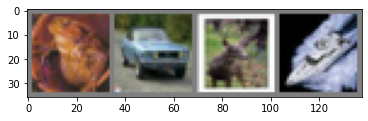

frog  car   deer  ship 


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주는 함수

def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# training image를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 출력
imshow(torchvision.utils.make_grid(images))

# label 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Convolutional Neural Network 정의하기

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
net = Net()

# Loss function & Optimizer

- Cross-Entropy loss
- SGD (with Momentum)

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

# 신경망 학습하기

In [12]:
for epoch in range(2): #데이터셋을 수차례 반복
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후
        inputs, labels = data

        #gradient 매개변수를 0으로
        optimizer.zero_grad()

        # 순전파, 역전파 푀적화 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력
        running_loss += loss.item()
        if i % 2000 == 1999:    
            # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.249
[1,  4000] loss: 1.928
[1,  6000] loss: 1.713
[1,  8000] loss: 1.589
[1, 10000] loss: 1.527
[1, 12000] loss: 1.476
[2,  2000] loss: 1.431
[2,  4000] loss: 1.379
[2,  6000] loss: 1.345
[2,  8000] loss: 1.332
[2, 10000] loss: 1.306
[2, 12000] loss: 1.277
Finished Training


# 학습 모델 저장

In [13]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Test

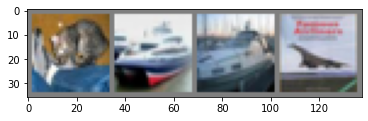

GroundTruth:  cat   ship  ship  plane


In [19]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지 출력
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [20]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [21]:
outputs = net(images)

In [22]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   car   car   plane


In [23]:
from cProfile import label


correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없음.
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산.
        outputs = net(images)
        # 가장 높은 값을 갖는 분류를 정답으로
        _, predicted = torch.max(outputs.data, 1)
        total += labels. size(0)
        correct += (predicted == labels).sum().item()
        

In [24]:
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


어떤 것을 잘 분류했고 못했는지 알아보기

In [25]:
# 각 class에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

#변화도는 여전히 필요 없음
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 class 별로 올바른 예측 수를 모은다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class : {classname:5s} is {accuracy : 1f}%')

Accuracy for class : plane is  62.500000%
Accuracy for class : car   is  79.200000%
Accuracy for class : bird  is  42.700000%
Accuracy for class : cat   is  17.000000%
Accuracy for class : deer  is  55.200000%
Accuracy for class : dog   is  42.200000%
Accuracy for class : frog  is  56.000000%
Accuracy for class : horse is  73.500000%
Accuracy for class : ship  is  71.500000%
Accuracy for class : truck is  53.300000%


# GPU에서 학습하기

device, net, input, labels를 모두 GPU로 보내줘야 한다.

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


In [ ]:
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)